In [16]:
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [17]:
steam_df = pd.read_csv('./data/steam-200k.csv', header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Other'])

In [18]:
steam_df.head(25)

,UserID,Game,Action,Hours,Other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
5,151603712,Spore,play,14.9,0
6,151603712,Fallout New Vegas,purchase,1.0,0
7,151603712,Fallout New Vegas,play,12.1,0
8,151603712,Left 4 Dead 2,purchase,1.0,0
9,151603712,Left 4 Dead 2,play,8.9,0


In [19]:
steam_df.value_counts()

UserID     Game                                          Action    Hours  Other
93275329   Grand Theft Auto Vice City                    purchase  1.0    0        2
116876958  Grand Theft Auto III                          purchase  1.0    0        2
27169419   Sid Meier's Civilization IV Beyond the Sword  purchase  1.0    0        2
           Sid Meier's Civilization IV                   purchase  1.0    0        2
46028967   Sid Meier's Civilization IV                   purchase  1.0    0        2
                                                                                  ..
127072755  Mortal Kombat Komplete Edition                purchase  1.0    0        1
                                                         play      0.3    0        1
           Just Cause 2 Multiplayer Mod                  purchase  1.0    0        1
                                                         play      0.7    0        1
5250       Alien Swarm                                   play      4.9

In [16]:
def parse(path):
    data = []
    g = gzip.open(path, 'r')
    for l in g:
        data.append(eval(l))
    return data

In [18]:
import gzip
review_data = parse('./data/steam_reviews.json.gz')

In [19]:
review_new = pd.DataFrame(review_data)

In [20]:
review_new.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


In [20]:
review_new.isna().sum()

NameError: name 'review_new' is not defined

In [21]:
play_data = steam_df[steam_df['Action'] == 'play']

In [26]:
play_data_new = play_data.drop(['Action', 'Other'], axis=1)

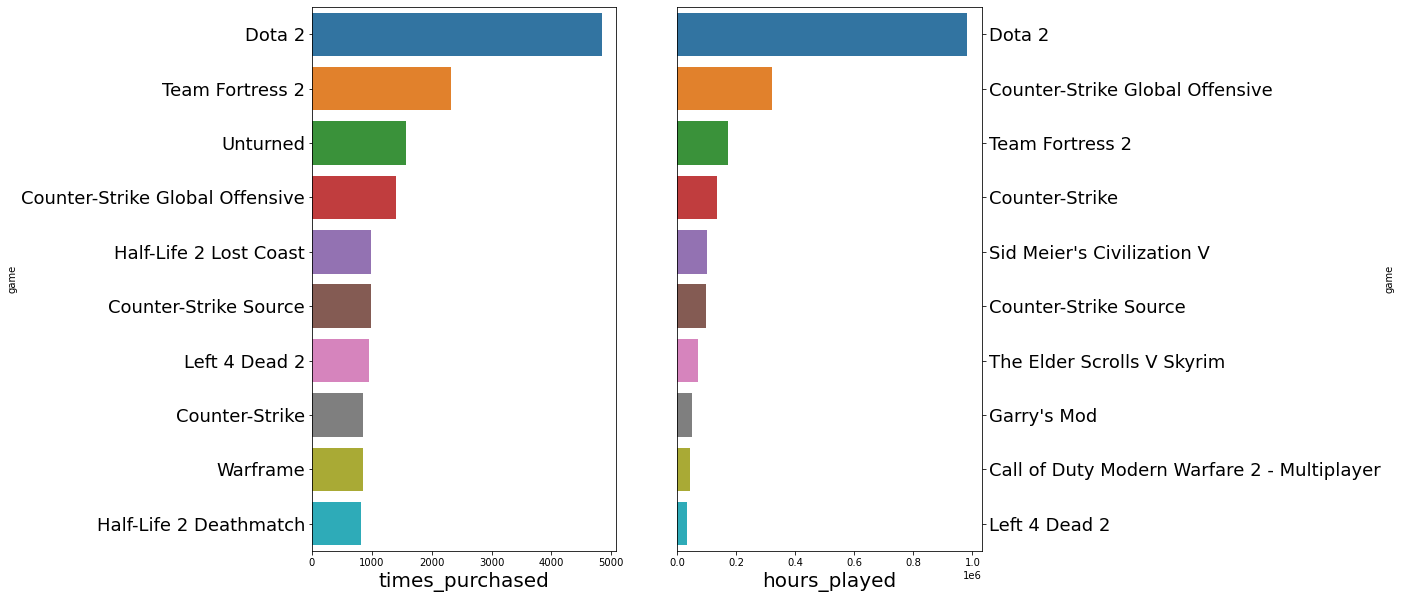

In [23]:
nb_games = 10
df_purchase = steam_df.loc[steam_df['Action'] == 'purchase']
purchased_times = df_purchase.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
purchased_times = pd.DataFrame({'game': purchased_times.index, 'times_purchased': purchased_times.values})[0:nb_games]

play_data = steam_df[steam_df['Action'] == 'play']
hours_played = play_data.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

fig, ax = plt.subplots(1,2,figsize=(12,nb_games))

sns.barplot(y = 'game', x = 'times_purchased', data = purchased_times, ax=ax[0])
sns.barplot(y = 'game', x = 'hours_played', data = hours_played, ax=ax[1])


ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
for i in range(0,2):
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].xaxis.label.set_size(20)

In [27]:
# Define the function to categorize hours
def categorize_hours(hours):
    if hours <= 20:
        return 'Low Engagement'
    elif 21 <= hours <= 100:
        return 'Moderate Engagement'
    elif 101 <= hours <= 500:
        return 'Good Engangement'
    elif 501 <= hours <= 1000:
        return 'Great Engangement'
    else:
        return 'Best Engagement'

# Apply the function to the 'Hours' column to create a new 'Reviews' column
play_data_new['Reviews'] = play_data_new['Hours'].apply(categorize_hours)

      UserID                        Game Action  Hours  Other  \
1  151603712  The Elder Scrolls V Skyrim   play  273.0      0   
3  151603712                   Fallout 4   play   87.0      0   
5  151603712                       Spore   play   14.9      0   
7  151603712           Fallout New Vegas   play   12.1      0   
9  151603712               Left 4 Dead 2   play    8.9      0   

               Reviews  
1     Good Engangement  
3  Moderate Engagement  
5       Low Engagement  
7       Low Engagement  
9       Low Engagement  


In [29]:
play_data_new.head(25)

,UserID,Game,Hours,Reviews
1,151603712,The Elder Scrolls V Skyrim,273.0,Good Engangement
3,151603712,Fallout 4,87.0,Moderate Engagement
5,151603712,Spore,14.9,Low Engagement
7,151603712,Fallout New Vegas,12.1,Low Engagement
9,151603712,Left 4 Dead 2,8.9,Low Engagement
11,151603712,HuniePop,8.5,Low Engagement
13,151603712,Path of Exile,8.1,Low Engagement
15,151603712,Poly Bridge,7.5,Low Engagement
17,151603712,Left 4 Dead,3.3,Low Engagement
19,151603712,Team Fortress 2,2.8,Low Engagement


In [30]:
play_data_new.tail(25)

,UserID,Game,Hours,Reviews
199943,99096740,SimCity 4 Deluxe,0.2,Low Engagement
199949,176449171,Dota 2,1310.0,Best Engagement
199951,176449171,Counter-Strike Global Offensive,704.0,Great Engangement
199953,176449171,PAYDAY 2,1.8,Low Engagement
199955,176449171,Team Fortress 2,0.9,Low Engagement
199961,221315846,Dota 2,9.0,Low Engagement
199963,221315846,Team Fortress 2,6.0,Low Engagement
199965,221315846,Tom Clancy's Ghost Recon Phantoms - EU,3.1,Low Engagement
199967,221315846,Quake Live,0.9,Low Engagement
199969,128470551,The Binding of Isaac Rebirth,291.0,Good Engangement


In [25]:
# Creating a pivot table for the user-item interaction matrix
# Users are the rows, games are the columns, and hours played are the values
user_item_matrix = play_data.pivot_table(index='UserID', columns='Game', values='Hours', fill_value=0)

# Displaying the shape and a portion of the matrix
user_item_matrix_shape = user_item_matrix.shape
user_item_matrix_head = user_item_matrix.head()

user_item_matrix_shape, user_item_matrix_head

((11350, 3600),
 Game    007 Legends  0RBITALIS  \
 UserID                           
 5250            0.0        0.0   
 76767           0.0        0.0   
 86540           0.0        0.0   
 144736          0.0        0.0   
 181212          0.0        0.0   
 
 Game    1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)  \
 UserID                                                               
 5250                                                  0.0            
 76767                                                 0.0            
 86540                                                 0.0            
 144736                                                0.0            
 181212                                                0.0            
 
 Game    10 Second Ninja  10,000,000  100% Orange Juice  1000 Amps  \
 UserID                                                              
 5250                0.0         0.0                0.0        0.0   
 76767               0.0    

In [32]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split

# Load the dataset
reader = Reader(rating_scale=(0, max(play_data['Hours'])))  # Assuming the scale goes from 0 to the maximum hours played
data = Dataset.load_from_df(play_data[['UserID', 'Game', 'Hours']], reader)

# Split the dataset into train and test sets
trainset, testset = train_test_split(data, test_size=0.25)

# Use SVD (or another algorithm)
algo = SVD()

# Train the algorithm on the trainset
algo.fit(trainset)

# Predictions
predictions = algo.test(testset)

# Compute and print the Root Mean Squared Error
accuracy.rmse(predictions, verbose=True)

# To make predictions for a specific game
def predict_hours_for_game(algo, game, user_ids):
    predictions = []
    for user_id in user_ids:
        predictions.append(algo.predict(uid=user_id, iid=game))
    return predictions

# Example usage
game_of_interest = "The Elder Scrolls V Skyrim"
predicted_hours = predict_hours_for_game(algo, game_of_interest, user_ids=play_data['UserID'].unique())

# You can then sort these predictions based on the estimated hours
sorted_predictions = sorted(predicted_hours, key=lambda x: x.est, reverse=True)

# And recommend the game to top users
top_user_recommendations = sorted_predictions[:5]  # Top 5 users


RMSE: 11703.9341
